# ***Variational Autoencoder (VAE) for MNIST Latent Representation and Image Generation***

Let us consider VAE model from *Auto-Encoding Variational Bayes (2014, D.P. Kingma et. al.)*.  
This work aims to implement a VAE model using Torch and apply it to the MNIST dataset.

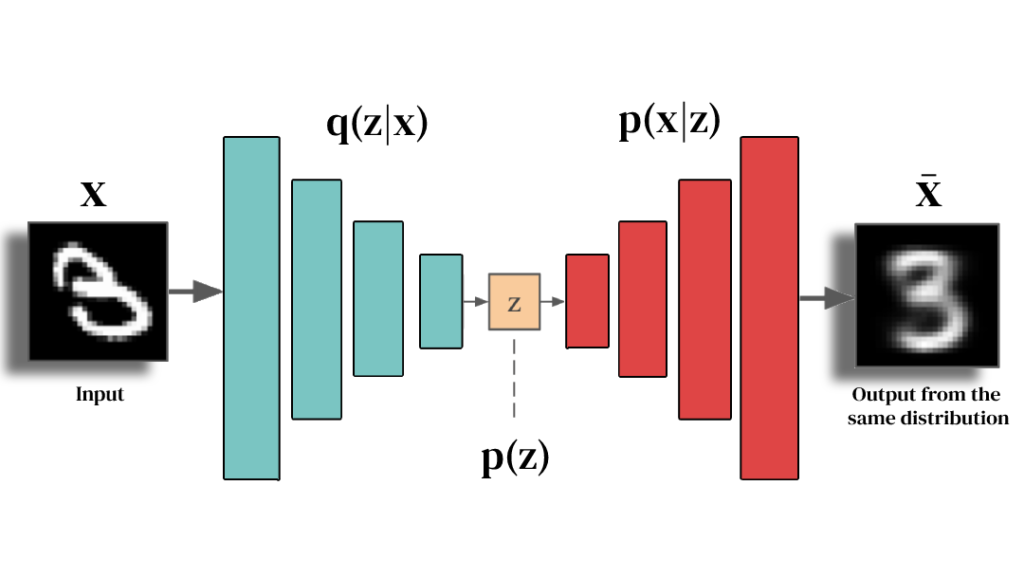

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

**Generative model:** We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.

## Implementation

### Step1: Model Hyperparameters



In [368]:
dataset_path = '~/datasets'

batch_size = 100

L = 10 # number of MC samples

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 400
latent_dim = 200

# Learning rate
lr = 1e-3

# Number of epoch
epochs = 5 # can try something greater if you are not satisfied with the results

### Step2: Load Dataset



In [356]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_labels = test_dataset.targets

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

### Step3: Define the model


In [357]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC stands for a fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # will use this to add non-linearity to our model

        self.training = True

    def forward(self, x):
        h_1     = self.LeakyReLU(self.FC_enc1(x))
        h_2     = self.LeakyReLU(self.FC_enc2(h_1))
        mean    = self.FC_mean(h_2)  # mean
        log_var = self.FC_var(h_2)   # log of variance

        return mean, log_var

In [358]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # again for non-linearity

    def forward(self, z):
        h_out_1  = self.LeakyReLU(self.FC_dec1(z))
        h_out_2  = self.LeakyReLU(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta

Reparameterization trick:

In [359]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        eps = torch.randn((L, batch_size, latent_dim))  # samples from standard normal
        mean = mean.unsqueeze(0)  # add dimension for L (1, batch_size, latent_dim) for broadcasting
        var = var.unsqueeze(0)  # add dimension for L (1, batch_size, latent_dim) for broadcasting
        z = mean + var * eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(log_var)) # takes exponential function (log var -> var)

        theta = self.Decoder(z)

        return theta, mean, log_var, z

### Step4: Model initialization

In [353]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = Model(Encoder=encoder, Decoder=decoder)

### Step5: Loss function and optimizer

Our objective function is ELBO:
$E_{q(z|x)}\big[\log \frac{p(x,z)}{q(z|x)}\big]$, which can be re-written as:

$$
\mathcal{L}= E_{q(z\mid x)} \Bigg[ \log \frac{p(x,z)}{q(z\mid x)}\Bigg] = E_{q(z\mid x)} \Bigg[ \log \frac{p(x\mid z) p(z)}{q(z\mid x)}\Bigg] = E_{q(z\mid x)}[\log p(x\mid z)] + E_{q(z\mid x)} \Bigg[ \log \frac{p(z)}{q(z\mid x)}\Bigg] = E_{q(z\mid x)}[\log p(x\mid z)] -  E_{q(z\mid x)} \Bigg[ \log \frac{q(z \mid x)}{p(z)}\Bigg] = E_{q(z\mid x)}[\log p(x\mid z)] - \int q(z \mid x) \log  \frac{q(z \mid x)}{p(z)} dz =  E_{q(z\mid x)}[\log p(x\mid z)] - D_{KL}(q(z\mid x) || p(z))
$$

***Consider the first term: $E_{q(z|x)}\big(\log p(x|z)\big)$***

$E_{q(z|x)}\big(\log p(x|z)\big) = \int q(z|x) \log p(x|z) dz $

We can approximate this integral by Monte Carlo integration as following:

$\approx \frac{1}{L} \sum_{l=1}^L \log p(x|z_l) $, where $z_l \sim q(z|x)$.

Now we can compute this term using the analytic expression for $p(x|z)$. ( Remember we model each pixel as a sample drawn from a Bernoulli distribution).

***Consider the second term: $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$***

Let us consider the K-dimensional multivariate Gaussians whose distribution are given by:
$$
q(z \mid x) = \mathcal{N}(\mu_q, \Sigma_q) = \frac{1}{(2\pi)^{\frac{K}{2}} |\Sigma_q|^{\frac{1}{2}}} \exp \Bigg( -\frac{1}{2} (z - \mu_q)^\top \Sigma_q^{-1} (z - \mu_q) \Bigg)
$$

$$
p(z \mid x) = \mathcal{N}(\mu_p, \Sigma_p) = \frac{1}{(2\pi)^{\frac{K}{2}} |\Sigma_p|^{\frac{1}{2}}} \exp \Bigg( -\frac{1}{2} (z - \mu_p)^\top \Sigma_p^{-1} (z - \mu_p) \Bigg)
$$

The KL divergence is defined as:
$$
D_{KL}=E_{q(z|x)}\Bigg[\log \frac{q(z\mid x)}{p(z)}\Bigg] = \frac{1}{2} \log \frac{|\Sigma_p|}{|\Sigma_q|} + \frac{1}{2} E_{q(z|x)}\Big[ (z - \mu_p)^\top \Sigma_p^{-1} (z - \mu_p) - (z - \mu_q)^\top \Sigma_q^{-1} (z - \mu_q)\Big]
$$

1)  The first part of the expectation is given by:
$$
E_{q(z|x)}[ (z - \mu_p)^\top \Sigma_p^{-1} (z - \mu_p) ] = E_{q(z|x)} \Bigg[ \sum_{i,j} (z_i - \mu_{p,i})  \Sigma_{p,ij}^{-1} (z_j - \mu_{p,j}) \Bigg]  = \sum_{i,j} \Sigma_{p,ij}^{-1} E_{q(z|x)} [(z_i - \mu_{p,i})  (z_j - \mu_{p,j}) ]
$$

$\quad$   where:
$$
(z_i - \mu_{p,i})(z_j - \mu_{p,j}) = (z_i - \mu_{q,i} + \mu_{q,i} - \mu_{p,i})(z_j - \mu_{q,j} + \mu_{q,j} - \mu_{p,j})
$$
$$
(z_i - \mu_{p,i})(z_j - \mu_{p,j}) = (z_i - \mu_{q,i})(z_j - \mu_{q,j}) + (z_i - \mu_{q,i})(\mu_{q,j} - \mu_{p,j}) + (\mu_{q,i} - \mu_{p,i})(z_j - \mu_{q,j}) + (\mu_{q,i} - \mu_{p,i})(\mu_{q,j} - \mu_{p,j})
$$

$\quad$  Therefore,
$$
E_{q(z|x)} [(z_i - \mu_{p,i})  (z_j - \mu_{p,j})] = E_{q(z|x)} \Bigg[(z_i - \mu_{q,i})(z_j - \mu_{q,j}) + (z_i - \mu_{q,i})(\mu_{q,j} - \mu_{p,j}) + (\mu_{q,i} - \mu_{p,i})(z_j - \mu_{q,j}) + (\mu_{q,i} - \mu_{p,i})(\mu_{q,j} - \mu_{p,j})\Bigg]
$$

$\quad$  With:
$\quad$ - $
E\left[ (z_i - \mu_{q,i})(z_j - \mu_{q,j}) \right] = \Sigma_{q,ij}, \quad \text{since} \quad z \sim \mathcal{N}(\mu_q, \Sigma_q)
$

$\quad$ $\quad$$\quad$ $\quad$ - $E\left[ (z_i - \mu_{q,i})(\mu_{q,j} - \mu_{p,j}) \right] = 0 \quad \text{because the second term is a constant shift, and the expectation of} \quad z_i - \mu_{q,i} \quad \text{is zero}
$

$\quad$ $\quad$$\quad$ $\quad$  - $E\left[ (\mu_{q,i} - \mu_{p,i})(z_j - \mu_{q,j}) \right] = 0 \quad \text{for the same reason}$

$\quad$ $\quad$$\quad$ $\quad$  - $E\left[ (\mu_{q,i} - \mu_{p,i})(\mu_{q,j} - \mu_{p,j}) \right] = (\mu_{q,i} - \mu_{p,i})(\mu_{q,j} - \mu_{p,j})$


$\quad$ Putting these terms together, we get:
$$
E_{q(z|x)}[ (z - \mu_p)^\top \Sigma_p^{-1} (z - \mu_p) ] = \sum_{i,j} \Bigg( \Sigma_{p,ij}^{-1} \Sigma_{q,ij} + (\mu_{q,i} - \mu_{p,i})\Sigma_{p,ij}^{-1}(\mu_{q,j} - \mu_{p,j}) \Bigg) =  \text{Tr}(\Sigma_p^{-1} \Sigma_q) + (\mu_q - \mu_p)^\top \Sigma_p^{-1} (\mu_q - \mu_p)
$$

2) The second part of the expectation is computed with:
$$
E_{q(z|x)}[ (z - \mu_q)^\top \Sigma_q^{-1} (z - \mu_q) ] = E_{q(z|x)} \Bigg[ \sum_{i,j} (z_i - \mu_{q,i})  \Sigma_{q,ij}^{-1} (z_j - \mu_{q,j}) \Bigg]  = \sum_{i,j} \Sigma_{q,ij}^{-1} E_{q(z|x)} [(z_i - \mu_{q,i})  (z_j - \mu_{q,j}) ]  = \sum_{i,j} \Sigma_{q,ij}^{-1} \Sigma_{q,ij} = \sum_{i,j} \Sigma_{q,ij}^{-1} \Sigma_{q,ji} = \text{Tr}(\Sigma_q^{-1} \Sigma_q) = K
$$

Therefore, the final general expression for the KL divergence is:
$$
D_{\text{KL}} = \frac{1}{2} \Big[ \text{Tr}(\Sigma_p^{-1} \Sigma_q) + (\mu_q - \mu_p)^\top \Sigma_p^{-1} (\mu_q - \mu_p) - K + \log \frac{|\Sigma_p|}{|\Sigma_q|} \Big]
$$

In our case, we further assume $\mu_p =0$ and $\Sigma_p=I$. The KL divergence simplifies to:
$$
D_{\text{KL}} = \frac{1}{2} \Big[ \text{Tr}(\Sigma_q) + \mu_q^\top \mu_q - K - \log |\Sigma_q| \Big] = \frac{1}{2}\sum_{k=1}^K \Bigg(\Sigma_{q,kk} + \mu_{q,k}^2 - 1 - \log \Sigma_{q,kk} \Bigg)
$$

In [369]:
from torch.optim import Adam

def loss_function(x, theta, mean, log_var): # should return the loss function (- ELBO)
    # likelihood
    x = x.unsqueeze(0)  # add the Monte Carlo dimension (batch_size, 1, x_dim)
    x = x.expand(theta.size(0), -1, -1)  # becomes (batch_size, L, x_dim)
    likelihood_per_sample = torch.sum(x * torch.log(theta + 1e-7) + (1 - x) * torch.log(1 - theta + 1e-7), dim=-1) # likelihood for each MC sample
    likelihood_MC = torch.mean(likelihood_per_sample, dim=0) # MC estimate for each data point
    likelihood = torch.mean(likelihood_MC) # mean of the batch
    
    # KL
    var = torch.exp(log_var)
    kl = 0.5 * torch.mean(torch.sum(var + mean**2 - 1 - log_var, dim=-1))

    loss =  kl - likelihood
    return loss

# optimizer
optimizer = Adam(model.parameters(), lr=lr)

### Step6: Train the model


In [257]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        theta, mean, log_var, z = model(x)
        loss = loss_function(x, theta, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  1.535718336917323
	Epoch 2 complete! 	Average Loss:  0.9414756674280946
	Epoch 3 complete! 	Average Loss:  0.804238374738741
	Epoch 4 complete! 	Average Loss:  0.7531956427164985
	Epoch 5 complete! 	Average Loss:  0.7238666456728825
Finish!!


### Step7: Generate images from test dataset
With our model trained, now we can start generating images.

First, we will generate images from the latent representations of test data.

Basically, we will sample $z$ from $q(z|x)$ and give it to the generative model (i.e., decoder) $p(x|z)$. The output of the decoder will be displayed as the generated image.

In [275]:
model.eval()
# below we get decoder outputs for test data
with torch.no_grad():
    z_test = []
    x_test = []
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x_test.append(x)
        z = model.forward(x)[-1]
        z_test.append(z)
        theta = model.forward(x)[0][0]

100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


Helper function to display images:

In [271]:
import matplotlib.pyplot as plt
def show_image(theta, idx):
    x_hat = theta.view(batch_size, 28, 28)
    #x_hat = Bernoulli(x_hat).sample() # sample pixel values (you can also try this, and observe how the generated images look)
    fig = plt.figure()
    plt.imshow(x_hat[idx].cpu().numpy(), cmap='gray')

Image from the test dataset:

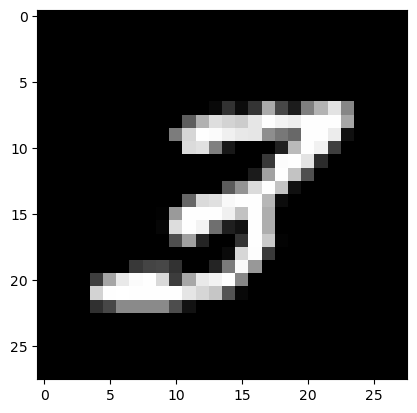

In [277]:
show_image(x, idx=25) # try different indices as well

Its reconstruction:

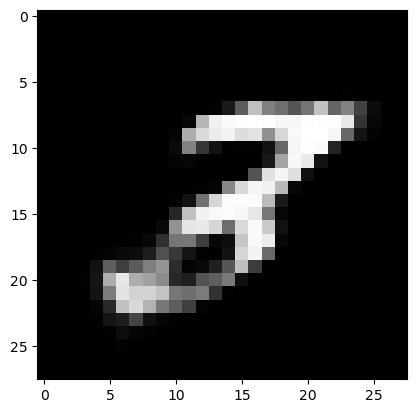

In [278]:
show_image(theta, idx=25)

### Step8: Generate images from noise

In the previous step, we sampled latent vector $z$ from $q(z|x)$. However, we know that the KL term in our loss function enforced $q(z|x)$ to be close to $N(0, I)$. Therefore, we can sample $z$ directly from noise $N(0, I)$, and pass it to the decoder $p(x|z)$.



In [279]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim)
    generated_images = decoder.forward(noise)

Display a couple of generated images:

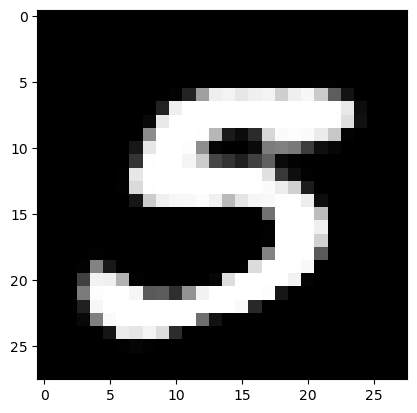

In [283]:
show_image(generated_images, idx=25)

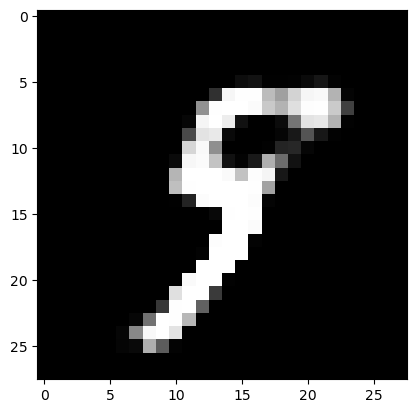

In [284]:
show_image(generated_images, idx=1)

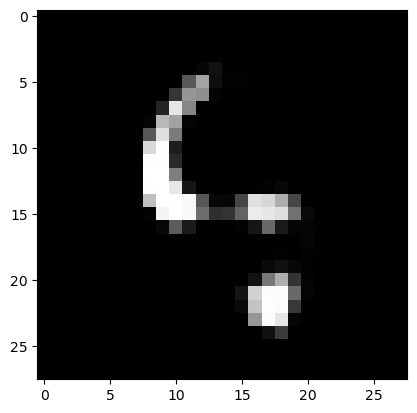

In [285]:
show_image(generated_images, idx=27)

### Step9: Latent representations

Beside data generation, VAEs are also commonly used to obtain low-dimensional representations of data and these representations are then used for downstream tasks. In this section, we will visualize the latent representations learned by your model.

To this end, we will first project them to 2D using t-SNE:

In [286]:
from sklearn.manifold import TSNE
def get_2d_representations(z):
    tsne = TSNE()
    rep_2D = tsne.fit_transform(z)
    return rep_2D

In [289]:
z_test_array = np.array(z_test)[:,0,:,:].reshape(10000,200)
x_test_array = np.array(x_test).reshape(10000,784)
# Project the latent representations of first 200 test data into 2D
rep_2d = get_2d_representations(z_test_array[:200,:])

C:\Users\cleme\anaconda3\envs\MLadvanced\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\cleme\anaconda3\envs\MLadvanced\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Now, visualize the latent space in 2D and comment on the plot:

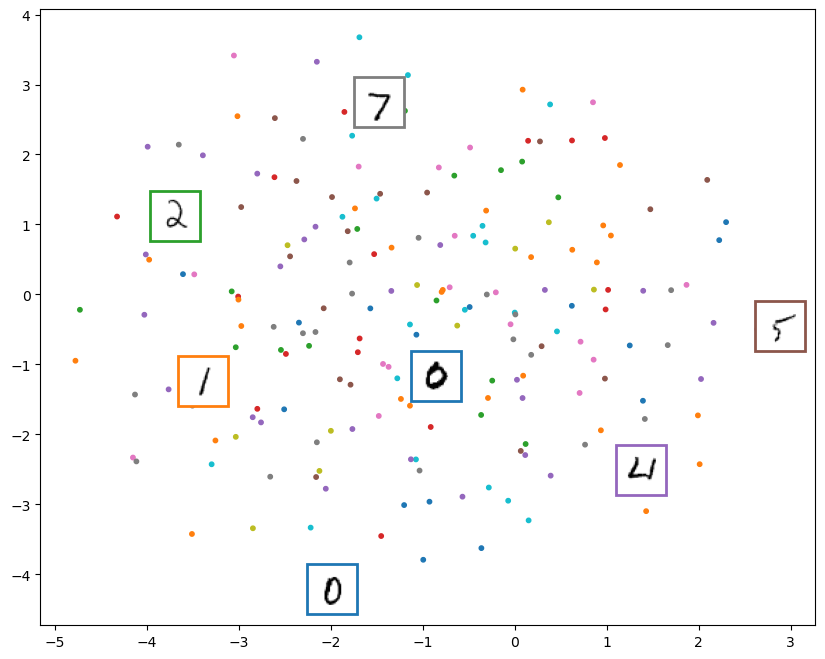

In [290]:
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
fig = plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(rep_2d[:, 0], rep_2d[:, 1], c=test_labels[:200], s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
dist_coord1 = np.max(rep_2d[:, 0]) - np.min(rep_2d[:, 0])
dist_coord2 = np.max(rep_2d[:, 1]) - np.min(rep_2d[:, 1])
target_dist = np.sqrt(dist_coord1**2+dist_coord2**2)/2
for index, position in enumerate(rep_2d):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > target_dist:  # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = AnnotationBbox(
              OffsetImage(x_test_array[index].reshape(28, 28), cmap="binary"),
              position,
              bboxprops={"edgecolor": tuple(cmap([test_labels[:200][index]])[0]), "lw": 2},
          )
          plt.gca().add_artist(imagebox)

The space distribution is messy and the different classes are uniformely spread over the entire space around the origin. The shape of the distribution is close from the prior standard normal. The latent representation is not meaningful and does not carry any information on the classes.

### Step10: Disentangled Latent Space
The KL term between the prior and the variational distributions often limits the latent representation capabilities of VAEs. One approach to overcome this problem is to use Maximum-Mean Discrepancy (MMD) instead of KL.

MMD is a framework to quantify the distance between two distributions by comparing all of their moments. It can be efficiently implemented using the kernel trick.  Letting $k(\cdot , \cdot)$ be any positive definite kernel, the
MMD between q and p is:
$D_{MMD}(q||p) = \mathbb{E}_{p(z),p(z')} \: \big[k(z,z')\big] - 2 \mathbb{E}_{q(z),p(z')}\: \big[k(z,z')\big] + \mathbb{E}_{q(z),q(z')}\: \big[k(z,z')\big]$

Implementation of MMD using RBF kernel:

In [360]:
def compute_rbf(x1: torch.Tensor, x2: torch.Tensor, latent_var: float = 2.0, eps: float = 1e-7) -> torch.Tensor:
    """
    Computes the RBF Kernel between x1 and x2.
    :param x1: (Tensor)
    :param x2: (Tensor)
    :param eps: (Float)
    :return:
    """
    z_dim = x2.size(-1)
    sigma = (2.0 / z_dim) * latent_var

    result = torch.exp(-((x1 - x2).pow(2).mean(-1) / sigma))
    return result

In [371]:
def MMD(prior_z: torch.Tensor, z: torch.Tensor):
    # compute pairwise RBF kernel values
    k_pp = compute_rbf(prior_z, prior_z)
    k_pq = compute_rbf(prior_z, z)
    k_qq = compute_rbf(z, z)
    
    # compute the MMD values
    mmd = k_pp - 2 * k_pq + k_qq
    return mmd

New loss function which involves MMD instead of KL:

In [362]:
def loss_mmd (x, theta, z):
    # likelihood
    x = x.unsqueeze(0)  # Add the Monte Carlo dimension (batch_size, 1, x_dim)
    x = x.expand(theta.size(0), -1, -1)  #  becomes (batch_size, L, x_dim)
    likelihood_per_sample = torch.sum(x * torch.log(theta + 1e-7) + (1 - x) * torch.log(1 - theta + 1e-7), dim=-1) # likelihood for each MC sample
    likelihood_MC = torch.mean(likelihood_per_sample, dim=0) # MC estimate for each data point
    likelihood = torch.mean(likelihood_MC) # mean of the batch
    
    # MMD
    prior_z = torch.randn_like(z) # prior samples
    mmd_per_sample = MMD(prior_z, z) # mmd for each MC sample
    mmd_MC = torch.mean(mmd_per_sample) # MC estimate for each data point
    mmd = torch.mean(mmd_MC) # mean of the batch
    
    loss =  mmd - likelihood
    return loss

Initialize another model and train it using the new loss:

In [363]:
encoder_2 = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder_2 = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
# new model
model_2 = Model(Encoder=encoder_2, Decoder=decoder_2)
# its optimizer
optimizer_2 = Adam(model_2.parameters(), lr=lr)

In [364]:
print("Start training VAE...")
model_2.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer_2.zero_grad()

        theta_2, mean_2, log_var_2, z_2 = model_2(x)
        loss_2 = loss_mmd(x, theta_2, z_2)

        overall_loss += loss_2.item()

        loss_2.backward()
        optimizer_2.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  1.2284263163775155
	Epoch 2 complete! 	Average Loss:  0.5987408288691398
	Epoch 3 complete! 	Average Loss:  0.4676377790957341
	Epoch 4 complete! 	Average Loss:  0.4057665851956019
	Epoch 5 complete! 	Average Loss:  0.36549965754972275
Finish!!


Obtain the latent representations of test set:

In [365]:
model_2.eval()
with torch.no_grad():
    z_test = []
    x_test = []
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x_test.append(x)
        # generate z, which will be displayed later
        z = model_2.forward(x)[-1]
        z_test.append(z)

100%|██████████| 100/100 [00:06<00:00, 15.56it/s]


Projection of the learned latent representations into 2D and visualization:

In [366]:
z_test_array = np.array(z_test)[:,1,:,:].reshape(10000,200)
x_test_array = np.array(x_test).reshape(10000,784)
rep_2d = get_2d_representations(z_test_array[:200,:])

C:\Users\cleme\anaconda3\envs\MLadvanced\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\cleme\anaconda3\envs\MLadvanced\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


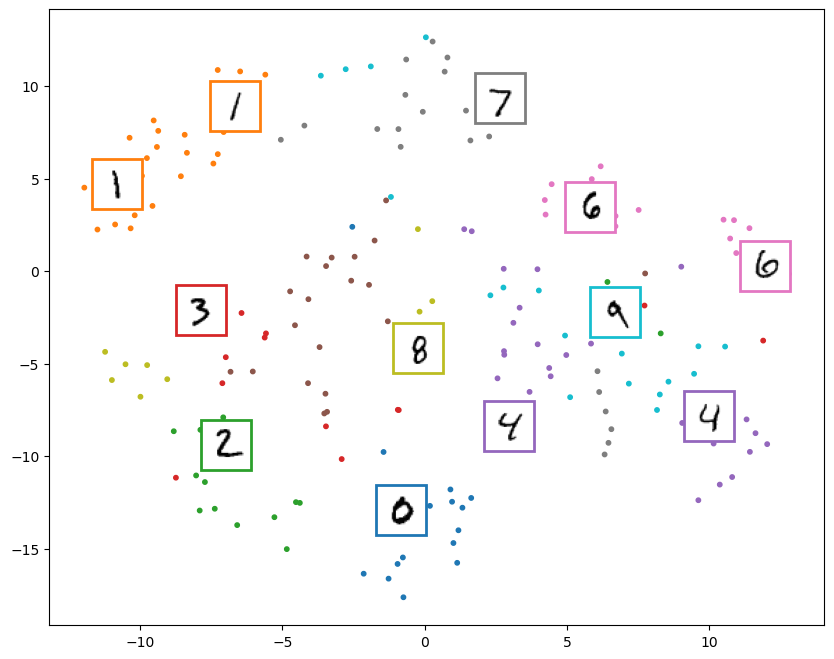

In [367]:
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
fig = plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(rep_2d[:, 0], rep_2d[:, 1], c=test_labels[:200], s=10, cmap=cmap)
image_positions = np.array([[1.0, 1.0]])
dist_coord1 = np.max(rep_2d[:, 0]) - np.min(rep_2d[:, 0])
dist_coord2 = np.max(rep_2d[:, 1]) - np.min(rep_2d[:, 1])
target_dist = np.sqrt(dist_coord1**2+dist_coord2**2)/1.5
for index, position in enumerate(rep_2d):
      dist = np.sum((position - image_positions) ** 2, axis=1)
      if np.min(dist) > target_dist:  # if far enough from other images
          image_positions = np.r_[image_positions, [position]]
          imagebox = AnnotationBbox(
              OffsetImage(x_test_array[index].reshape(28, 28), cmap="binary"),
              position,
              bboxprops={"edgecolor": tuple(cmap([test_labels[:200][index]])[0]), "lw": 2},
          )
          plt.gca().add_artist(imagebox)

The latent space is much more meaningful with the MMD loss function. The similar instances are clustered and mapped in nearby regions. The global shape of the distribution does not look exactly like the prior standard normal.

On the one hand, KL divergence explicitky measures the difference between the approximate posterior and the prior. It ensures that they stay close from each other. 
On the other hand, the MMD loss encourages the samples from $q(z \mid x)$ to look like they were drawn from $p(z)$ but does not explicitly enforce the shapes of the distributions to match. It accurately preserves and represents the inherent relations between the different data points. 

The MMD approach may be more advantageous in many scenarios. In the context of VAEs for instance, when generating data to fix class imbalance in a dataset, the MMD approach may allow generating samples that closely resemble the minority class distribution. By preserving the local structure of the latent space, MMD ensures that the generated samples for the minority class are not only realistic but also diverse within the specific regions corresponding to that class. In medical imaging, datasets often lack sufficient samples for rare diseases. This approach may enable to generate realistic scans of rare tumor types to improve diagnostic models in radiology.
Another example is the implementation of recommendation systems that are designed to predict user preferences, such as movie genres or e-commerce products. User preferences are often clustered to make relevant suggestions. The MMD approach can create latent spaces where users with similar preferences are grouped together. When generating recommendations, the system can target specific clusters, ensuring that the generated recommendations are personalized and relevant to each user group.